In [1]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random

# Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Operating System
import os
from datetime import datetime

# Oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Mathematics and Statistics
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import loguniform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1 - Data Preparation¶

## 1.1 - Load Data
### [Data Source](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- It contains only numerical input variables which are the result of a PCA transformation. 
- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [2]:
All_Data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
All_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [3]:
print('Actual Bad Rate:'+str(All_Data['Class'].mean()))

Actual Bad Rate:0.001727485630620034


In [4]:
X_Data = All_Data.drop(['Class'],axis=1)
Y_Data = All_Data['Class']

## 1.2 - Oversampling
## Consider three methods for oversampling
#### - Naive random oversampling
#### - SMOTE
#### - ADASYN

#### [More about the oversampling is discussed in this notebook](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/credit_card_fraud_EAD_oversampling.ipynb). 

In [5]:
Created_Sample_Method  = ["random","SMOTE","ADASYN"]
if "random" in Created_Sample_Method:
    X_rosampled, Y_rosampled = RandomOverSampler().fit_resample(X_Data, Y_Data)
if "SMOTE" in Created_Sample_Method:
    X_SMOTE, Y_SMOTE         = SMOTE().fit_resample(X_Data, Y_Data)
if "ADASYN" in Created_Sample_Method:
    X_ADASYN, Y_ADASYN       = ADASYN().fit_resample(X_Data, Y_Data)

# 2 - Random Search
#### The [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) function will be used in this notebook to conduct random search.

#### Create the light gradient boosting (LGB) estimator. Specify hyperparameters that are going to be tuned.

In [6]:
params_LGB = {'boosting_type' : 'gbdt',     ## default = 'gbdt'
              'objective'     : 'binary'   ## default = 'binary'
             }
lgb_estimator = lgb.LGBMClassifier(**params_LGB)

In [7]:
##### in stats.uniform(a,b): "a: is the lower bound, and "b" is the upper bound
##### in stats.loguniform(a,b): "a" is location parameter, and "b" is the scale parameter, 
#####                           so the bound is [a, a+b].
##### in randint(a,b): "a" in the lower bound, "b" is the upper bound +1 (i.e., b will not be sampled)
params_lgb_dict= {
    'colsample_bytree' : stats.uniform(0.2,0.8),        ## default = 1.0
    'learning_rate'    : stats.loguniform(0.001,0.2),   ## default = 0.1
    'min_child_samples': stats.randint(5,101),          ## default = 20
    'min_child_weight' : stats.loguniform(0.001,10),    ## default = 1e-3
    'max_depth'        : [-1,5,6,7,8],                  ## default = -1
    'n_estimators'     : stats.randint(50,1001),        ## default = 100
    'min_split_gain'   : stats.uniform(0,1),            ## default = 0
    'num_leaves'       : stats.randint(15,129),         ## default = 31
    'subsample_for_bin': stats.randint(2000,40001),     ## default = 200000
    'subsample_freq'   : stats.randint(0,11)            ## default = 0
}

Countinuous_HP = ['colsample_bytree','learning_rate','min_child_samples','min_child_weight','n_estimators',
                  'min_split_gain','num_leaves','subsample_for_bin','subsample_freq']
Discrete_HP    = ['max_depth']

#### The function for conducting Random Search

In [8]:
def Run_RS(Selected_Sample_Method,estimator,N_Iteration,params_lgb_dict,metric):
    if Selected_Sample_Method == "none":
        X_Data_new = X_Data; Y_Data_new = Y_Data; 
    if Selected_Sample_Method == "random":
        X_Data_new = X_rosampled; Y_Data_new = Y_rosampled; 
    if Selected_Sample_Method == "SMOTE":
        X_Data_new = X_SMOTE; Y_Data_new = Y_SMOTE; 
    if Selected_Sample_Method == "ADASYN":
        X_Data_new = X_ADASYN; Y_Data_new = Y_ADASYN; 
    
    ##### Shuffling (Becasue after oversampling the )
    All_shuffle  = pd.concat([X_Data_new, Y_Data_new.rename("Class")], axis=1)
    All_shuffle  = All_shuffle.sample(frac=1).reset_index(drop=True)
    X_Data_new   = All_shuffle.drop(['Class'],axis=1)
    Y_Data_new   = All_shuffle['Class']
    
    ##### Define RandomSearch estimator
    RS = RandomizedSearchCV(
        estimator           = estimator,
        param_distributions = params_lgb_dict,
        n_iter              = N_Iteration,
        scoring             = metric,
        cv                  = 3,
        ##### verbose = 1:computation time; 2:1+score; 3:2+hyperparameter values
        verbose             = 0)
    
    RS_now  = RS.fit(X_Data_new,Y_Data_new)

    RS_Plot = pd.DataFrame.from_dict(RS_now.cv_results_)    
    return(RS_Plot)

#### The function for visualize the random search research results (mainly using scatter plots)

In [9]:
def Plot_SearchResult(df,Countinuous_HP,Discrete_HP):
    def Plot_Continuous(df,para):
        plt.figure(figsize=(4, 3))
        sns.scatterplot(df,x='param_'+para,y='mean_test_score')
        #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title(para)
        plt.show()
        return()
    
    def Plot_Discrete(df,para):
        para = 'param_'+para
        df_sorted = df.sort_values(para)
        plt.figure(figsize=(4, 3))
        sns.scatterplot(df_sorted,x=range(len(df_sorted)),y='mean_test_score',hue=para,palette="Set1")
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.title(para)
        plt.show()
        return()
    for f in Countinuous_HP:
        Plot_Continuous(df,f)   
    for f in Discrete_HP:
        Plot_Discrete(df,f)
    return

### Next, conduct random search with the following parameters:
#### - Selected_Sample_Method: none, random, SMOTE, ADASYN
#### - Metric: neg_log_loss (this notebook only used logloss, other options include roc_auc, average_precision, etc.)

In [10]:
### A function to conduct and save the random search result
def conduct_RS(Selected_Sample_Method):
    RS_now = Run_RS(Selected_Sample_Method = Selected_Sample_Method,
                    estimator              = lgb_estimator,
                    N_Iteration            = 100,
                    params_lgb_dict        = params_lgb_dict,
                    metric                 = 'neg_log_loss')
    filename = '/kaggle/working/RS_'+Selected_Sample_Method+'.csv'
    RS_now.to_csv(filename,index=False)
    

### These processes take time. 
### Run a tuning, or load existing tuning restuls.  

In [11]:
##### 1 or 0
RERUN_RS = 0

## 2.1 - Random Search on Raw Data 

In [12]:
if (RERUN_RS == 1):
    conduct_RS(Selected_Sample_Method='none')
else:
    RS_none = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/RS_none.csv')

In [13]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
RS_none.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
45,5,0.678362,0.010739,94,4.802916,878,0.862906,68,35653,10,-0.002540,1
88,7,0.557755,0.013008,95,5.573129,928,0.930018,127,25278,8,-0.002555,2
9,6,0.618457,0.025106,28,6.889943,246,0.405145,50,10817,10,-0.002568,3


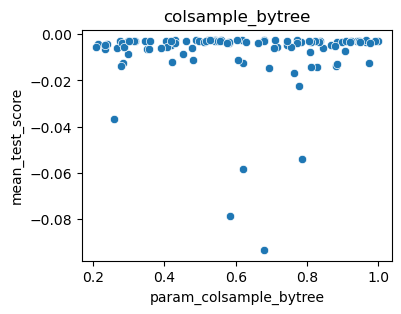

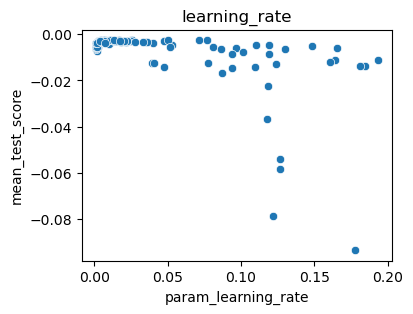

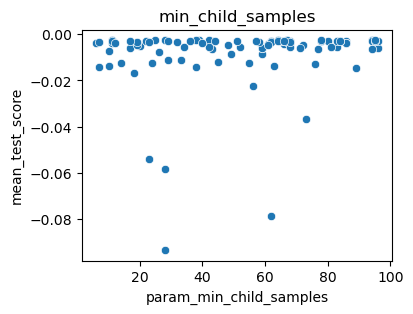

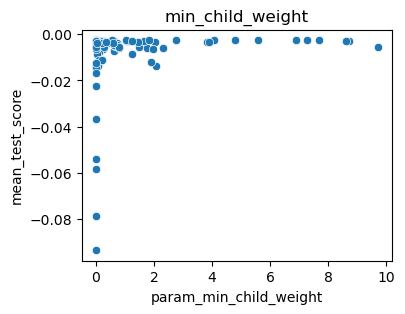

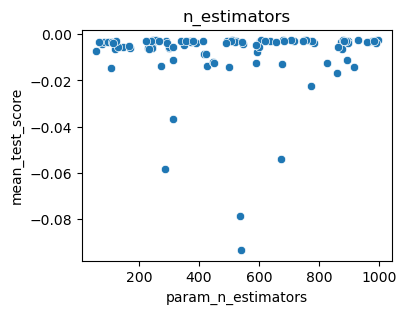

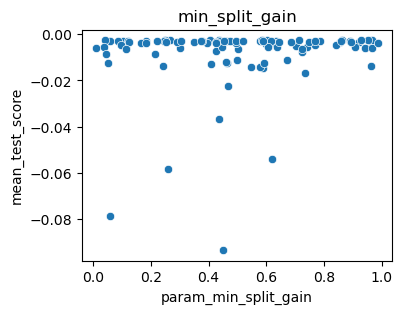

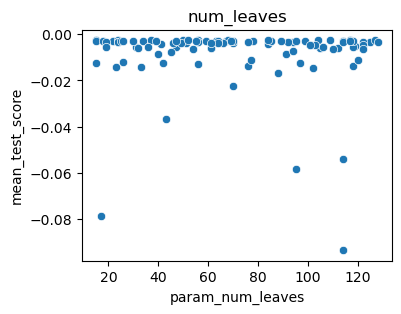

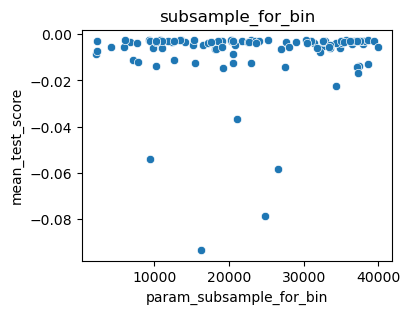

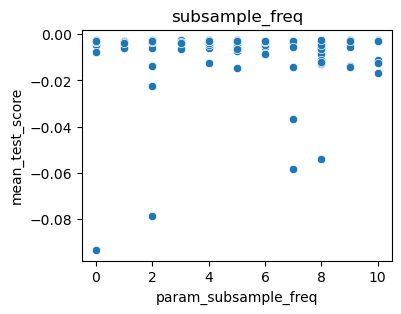

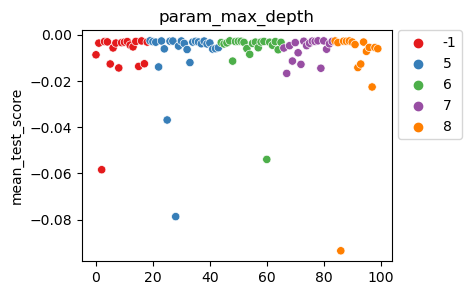

In [14]:
Plot_SearchResult(RS_none,Countinuous_HP,Discrete_HP)

## 2.2 - Random Search on Random Oversampled Data

In [15]:
if (RERUN_RS == 1):
    conduct_RS(Selected_Sample_Method='random')
else:
    RS_random = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/RS_random.csv')

In [16]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
RS_random.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
11,8,0.377240,0.029550,43,0.025044,886,0.036435,52,16625,10,-0.000364,1
61,-1,0.528993,0.060599,87,3.494089,873,0.026250,122,14481,7,-0.000367,2
71,6,0.967949,0.062437,27,0.003612,809,0.037444,71,34185,7,-0.000369,3


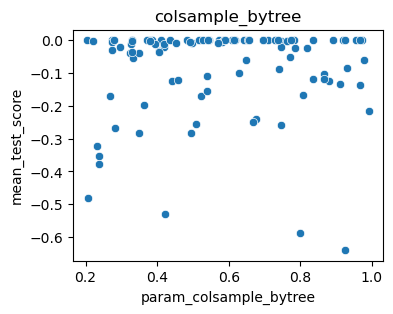

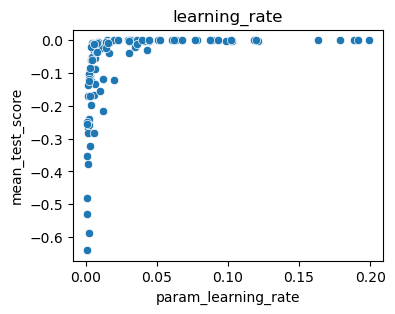

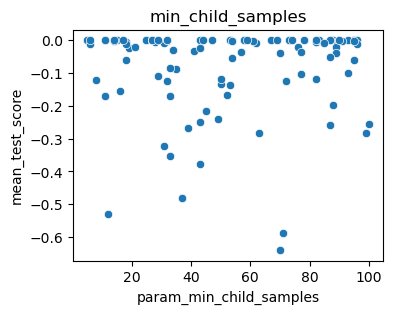

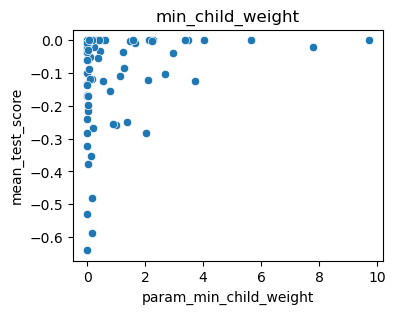

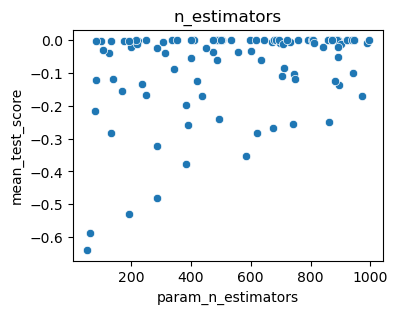

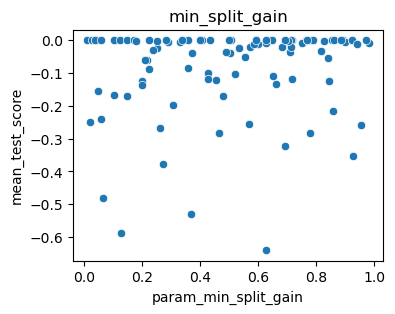

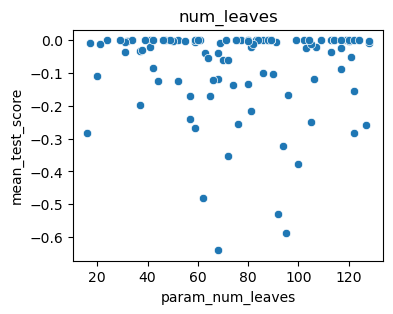

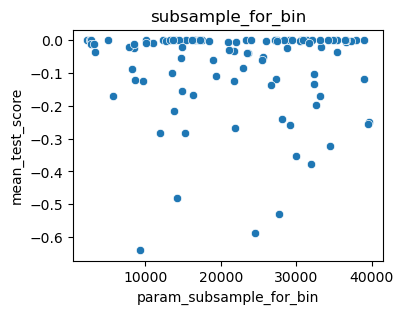

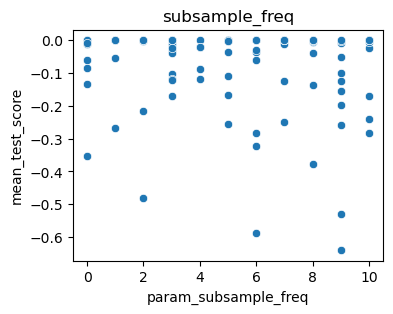

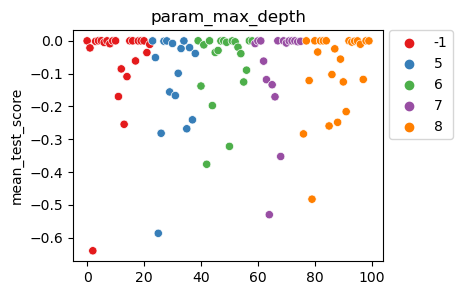

In [17]:
Plot_SearchResult(RS_random,Countinuous_HP,Discrete_HP)

## 2.3 - Random Search on SMOTE Oversampled Data

In [18]:
if (RERUN_RS == 1):
    conduct_RS(Selected_Sample_Method='SMOTE')
else:
    RS_SMOTE = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/RS_SMOTE.csv')

In [19]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
RS_SMOTE.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
9,8,0.805322,0.092051,33,0.505005,609,0.049186,62,33266,2,-0.000729,1
14,6,0.633147,0.094682,20,0.011519,858,0.089129,91,25890,2,-0.000813,2
7,8,0.459335,0.151530,37,2.416803,259,0.186561,60,8967,1,-0.000859,3


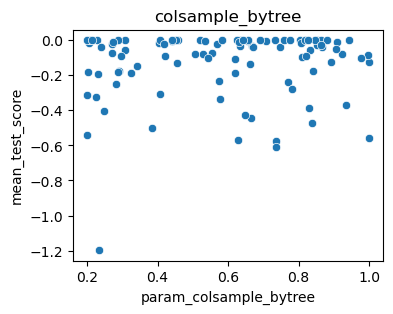

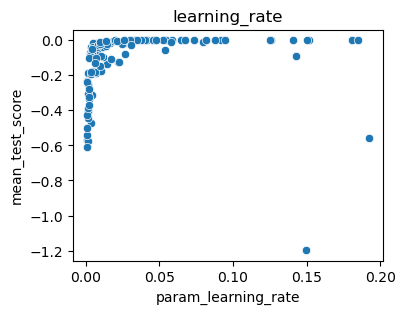

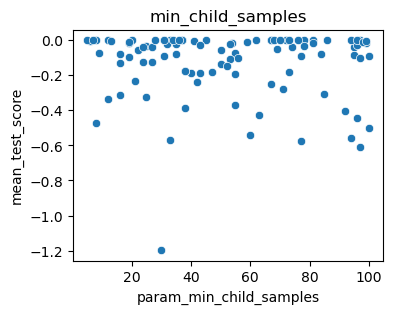

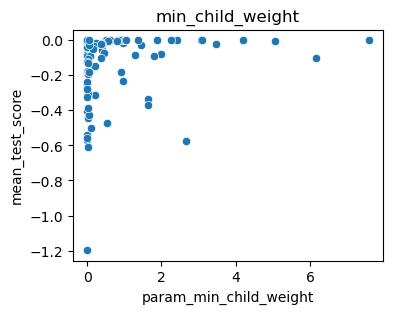

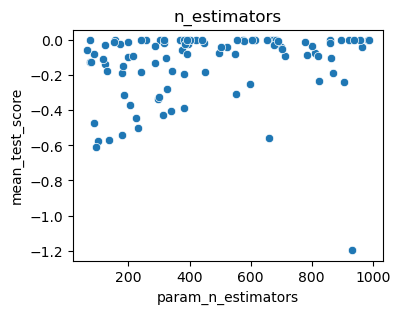

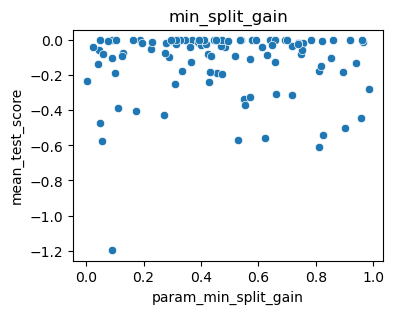

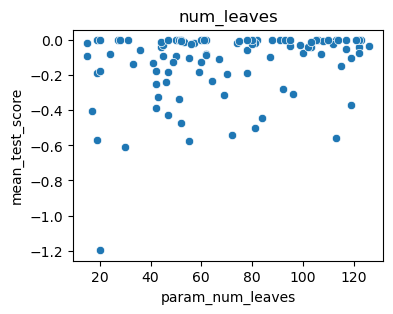

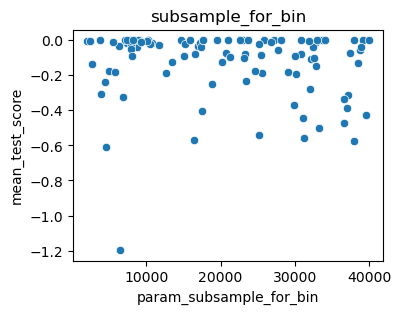

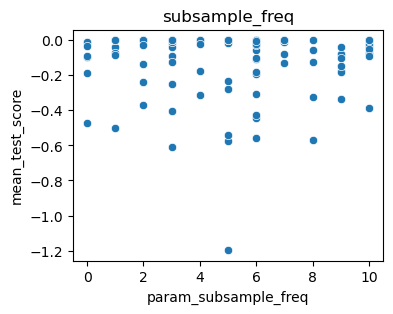

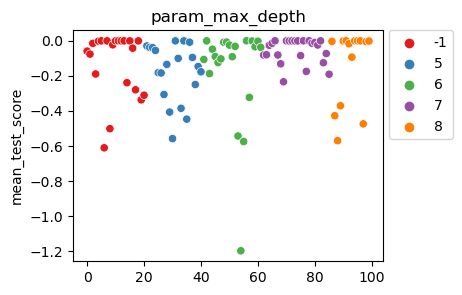

In [20]:
Plot_SearchResult(RS_SMOTE,Countinuous_HP,Discrete_HP)

## 2.4 - Random Search on ADASYN Oversampled Data

In [21]:
if (RERUN_RS == 1):
    conduct_RS(Selected_Sample_Method='ADASYN')
else:
    RS_ADASYN = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/RS_ADASYN.csv')

In [22]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
RS_ADASYN.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
22,6,0.741738,0.082535,81,0.072051,962,0.075531,18,4025,6,-0.000748,1
41,8,0.320638,0.033988,78,0.895596,633,0.101307,98,10706,2,-0.000793,2
88,-1,0.470432,0.031805,60,1.702468,444,0.008763,77,34189,4,-0.000912,3


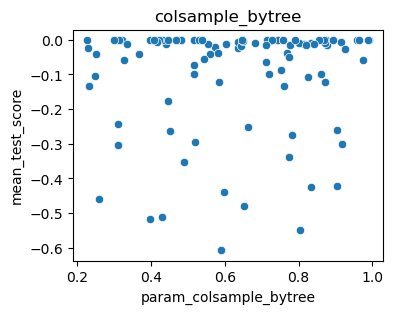

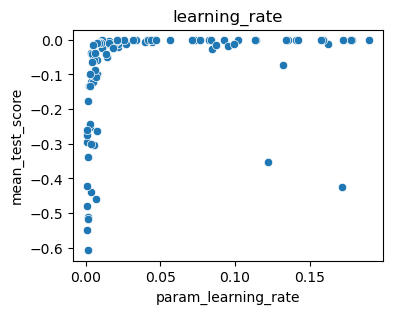

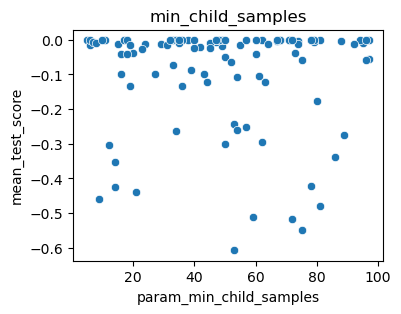

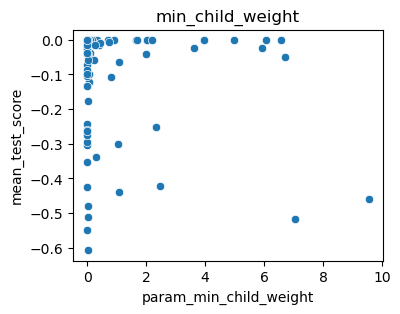

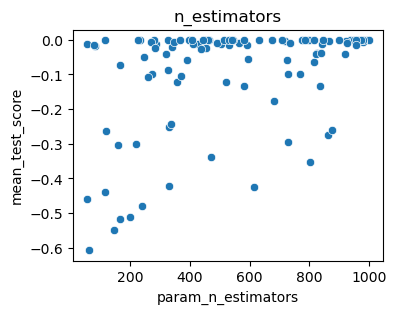

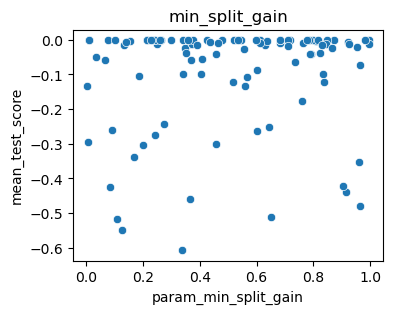

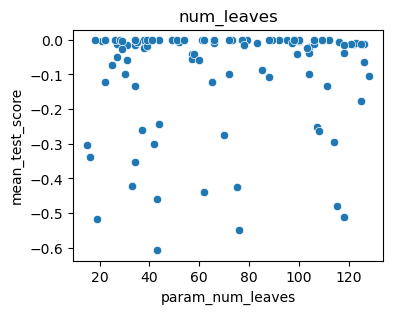

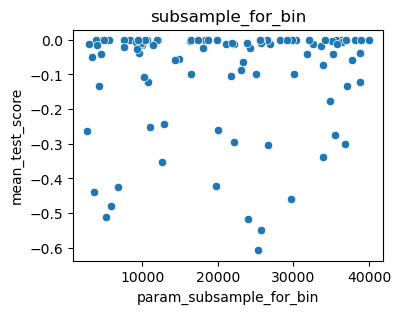

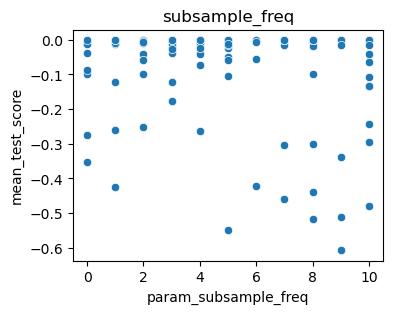

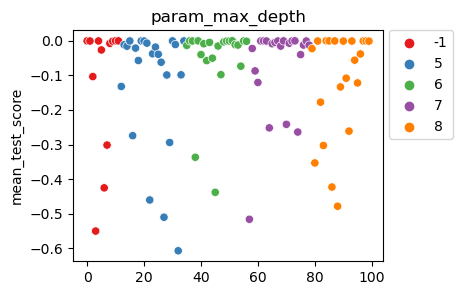

In [23]:
Plot_SearchResult(RS_ADASYN,Countinuous_HP,Discrete_HP)

# @@@@@ 3 - BayesSearchCV
##### skopt.BayesSearchCV: Bayesian optimization over hyper parameters.
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV
##### skopt.space.space.Space: Initialize a search space from given specifications.
https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.space

In [24]:
params_LGB = {'boosting_type' : 'gbdt',     ## default = 'gbdt'
              'objective'     : 'binary'    ## default = 'binary'
             }
lgb_estimator = lgb.LGBMClassifier(**params_LGB)

In [25]:
##### in stats.uniform(a,b): "a: is the lower bound, and "b" is the upper bound
##### in stats.loguniform(a,b): "a" is location parameter, and "b" is the scale parameter, so the bound is [a, a+b].
##### in randint(a,b): "a" in the lower bound, "b" is the upper bound +1 (i.e., b will not be sampled)
params_lgb_dict= {
    'colsample_bytree' : Real(0.2,1,prior='uniform'),        ## default = 1.0
    'learning_rate'    : Real(0.001,0.2,prior='log-uniform'),   ## default = 0.1
    'min_child_samples': Integer(5,101,prior='uniform'),         ## default = 20
    'min_child_weight' : Real(0.001,10,prior='log-uniform'),    ## default = 1e-3
    'max_depth'        : Categorical([-1,5,6,7,8]),                  ## default = -1
    'n_estimators'     : Integer(50,1000,prior='uniform'),        ## default = 100
    'min_split_gain'   : Real(0,1,prior='uniform'),            ## default = 0
    'num_leaves'       : Integer(16,128,prior='uniform'),         ## default = 31
    'subsample_for_bin': Integer(2000,40000,prior='uniform'),     ## default = 200000
    'subsample_freq'   : Integer(0,10,prior='uniform')            ## default = 0
}

Countinuous_HP = ['colsample_bytree','learning_rate','min_child_samples','min_child_weight','n_estimators',
                  'min_split_gain','num_leaves','subsample_for_bin','subsample_freq']
Discrete_HP    = ['max_depth']

In [26]:
def Run_BS(Selected_Sample_Method,estimator,N_Iteration,params_lgb_dict,metric):
    if Selected_Sample_Method == "none":
        X_Data_new = X_Data; Y_Data_new = Y_Data; 
    if Selected_Sample_Method == "random":
        X_Data_new = X_rosampled; Y_Data_new = Y_rosampled; 
    if Selected_Sample_Method == "SMOTE":
        X_Data_new = X_SMOTE; Y_Data_new = Y_SMOTE; 
    if Selected_Sample_Method == "ADASYN":
        X_Data_new = X_ADASYN; Y_Data_new = Y_ADASYN; 
    
    ##### Shuffling (Becasue after oversampling the )
    All_shuffle  = pd.concat([X_Data_new, Y_Data_new.rename("Class")], axis=1)
    All_shuffle  = All_shuffle.sample(frac=1).reset_index(drop=True)
    X_Data_new   = All_shuffle.drop(['Class'],axis=1)
    Y_Data_new   = All_shuffle['Class']
    
    ##### Define RandomSearch estimator
    BS = BayesSearchCV(
        estimator           = estimator,
        search_spaces       = params_lgb_dict,
        n_iter              = N_Iteration,
        cv                  = 3,
        scoring             = metric,
        verbose             = 0)
    
    BS_now  = BS.fit(X_Data_new,Y_Data_new)

    RS_Plot = pd.DataFrame.from_dict(BS_now.cv_results_)    
    return(RS_Plot)

In [27]:
### A function to conduct and save the Bayesian optimization search result
def conduct_BS(Selected_Sample_Method):
    BS_now = Run_BS(Selected_Sample_Method = Selected_Sample_Method,
                    estimator              = lgb_estimator,
                    N_Iteration            = 100,
                    params_lgb_dict        = params_lgb_dict,
                    metric                 = 'neg_log_loss')
    filename = '/kaggle/working/BS_'+Selected_Sample_Method+'.csv'
    BS_now.to_csv(filename,index=False)
    

In [28]:
##### 1 or 0
RERUN_BS = 0

## 3.1 - Bayesian Search on Raw Data 

In [29]:
if (RERUN_BS == 1):
    conduct_BS(Selected_Sample_Method='none')
else:
    BS_none = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/BS_none.csv')

In [30]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
BS_none.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
93,-1,0.86399,0.027701,101,10.00000,1000,1.0,16,2000,0,-0.002517,1
96,-1,1.00000,0.007369,101,4.90898,1000,1.0,16,2000,10,-0.002525,2
40,8,1.00000,0.043120,96,10.00000,1000,1.0,128,40000,0,-0.002539,3


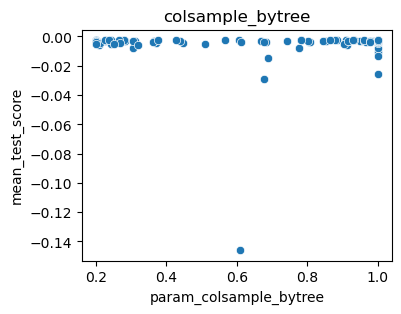

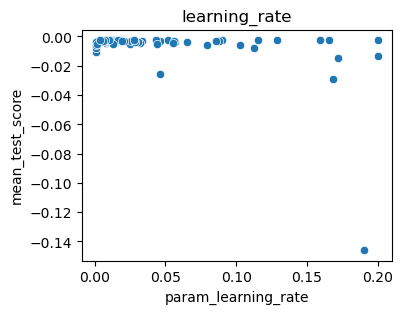

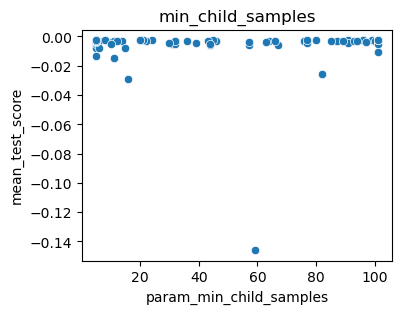

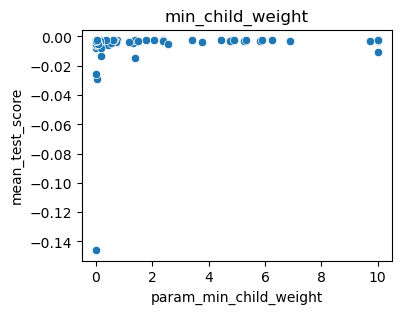

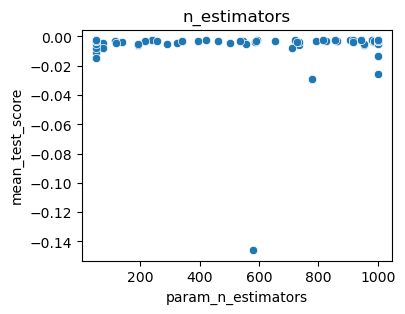

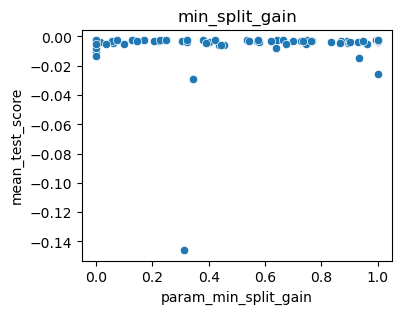

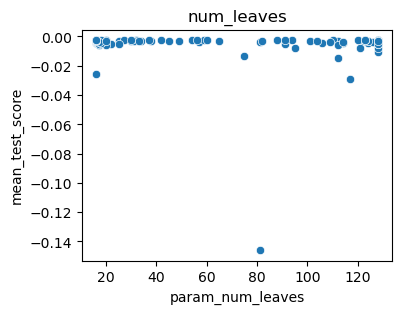

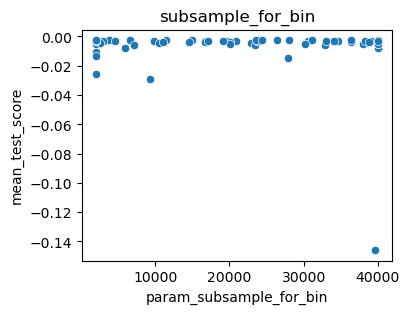

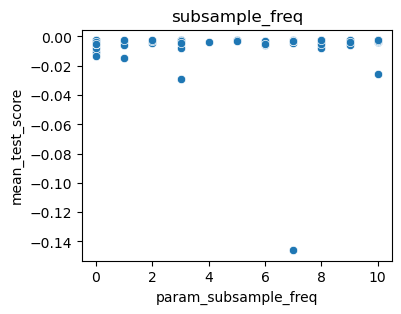

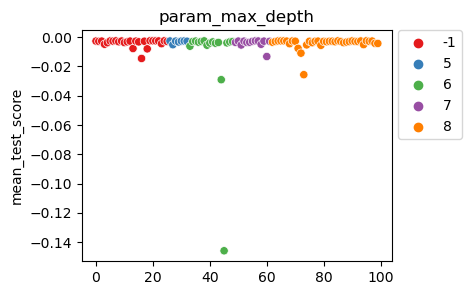

In [31]:
Plot_SearchResult(BS_none,Countinuous_HP,Discrete_HP)

## 3.2 - Bayesian Search on Random Oversampled Data

In [32]:
if (RERUN_BS == 1):
    conduct_BS(Selected_Sample_Method='random')
else:
    BS_random = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/BS_random.csv')

In [33]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
BS_random.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
62,7,0.334434,0.028869,61,0.001122,1000,0.018045,111,40000,4,-0.000359,1
54,6,0.212768,0.025683,64,0.001226,1000,0.000000,52,2000,10,-0.000408,2
67,5,0.786370,0.200000,94,4.242953,1000,0.000000,29,40000,8,-0.000434,3


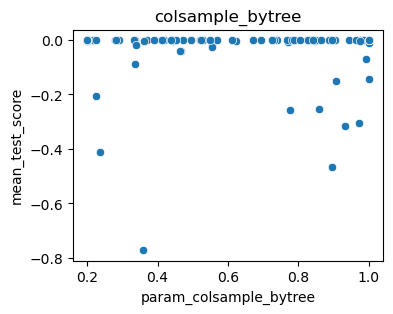

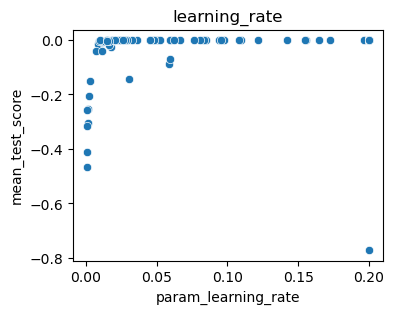

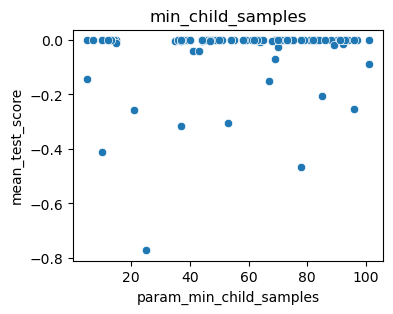

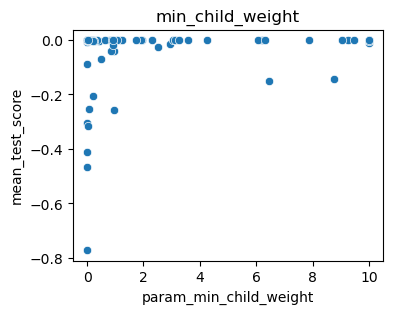

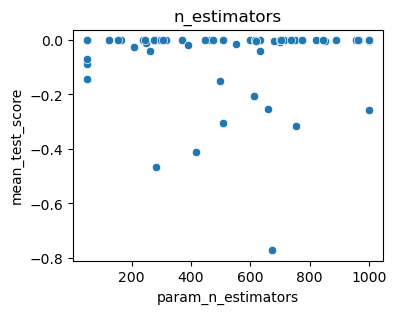

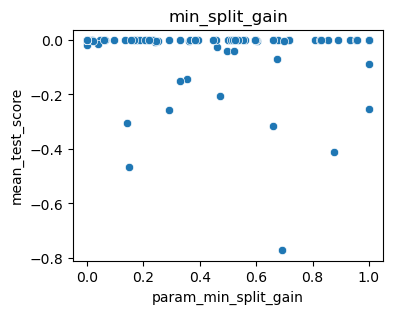

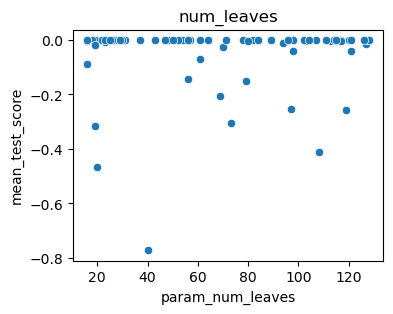

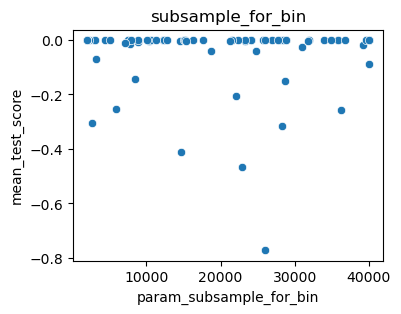

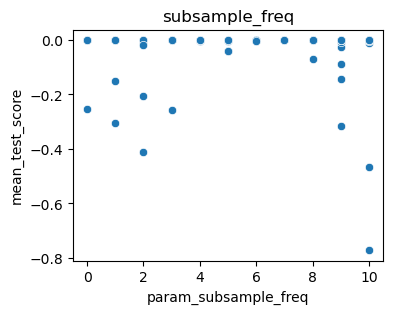

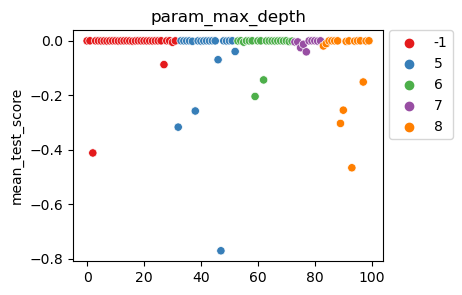

In [34]:
Plot_SearchResult(BS_random,Countinuous_HP,Discrete_HP)

## 3.3 - Bayesian Search on SMOTE Oversampled Data

In [35]:
if (RERUN_BS == 1):
    conduct_BS(Selected_Sample_Method='SMOTE')
else:
    BS_SMOTE = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/BS_SMOTE.csv')

In [36]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
BS_SMOTE.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
34,8,0.2,0.055597,5,0.039435,1000,0.0,128,2000,10,-0.000599,1
57,8,0.2,0.071573,101,0.006057,630,0.0,128,40000,0,-0.000616,2
80,8,0.2,0.027484,5,0.019713,1000,0.0,128,40000,10,-0.000619,3


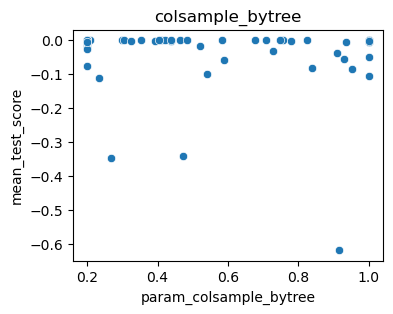

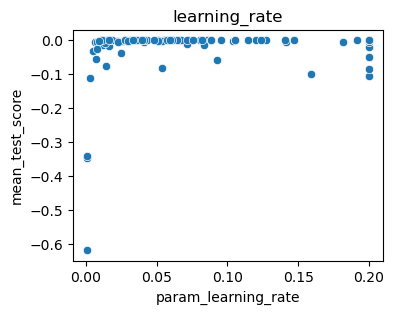

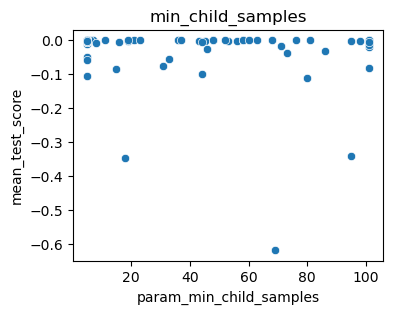

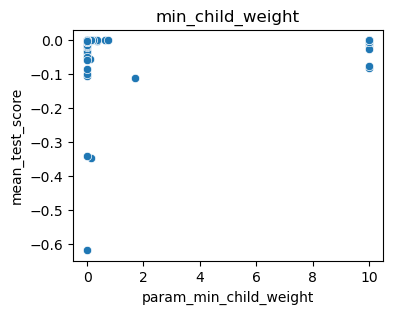

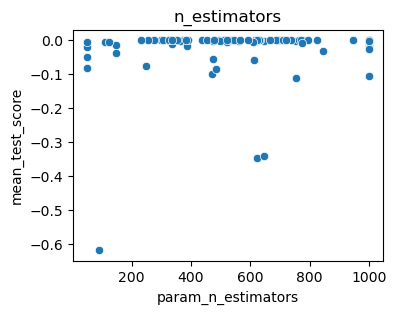

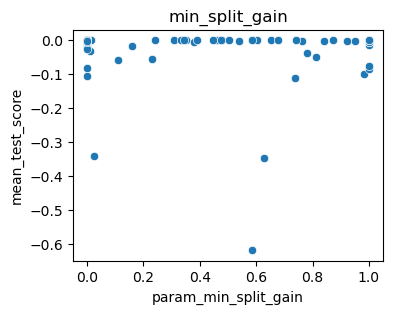

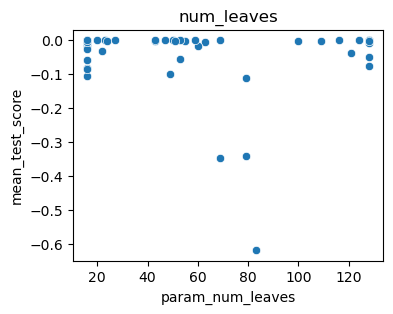

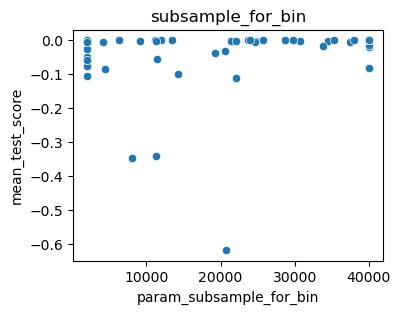

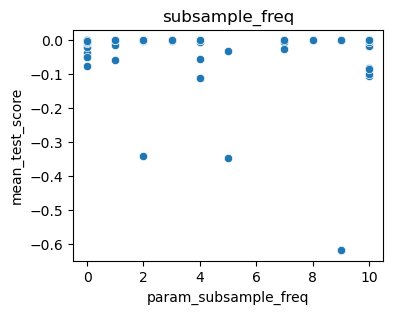

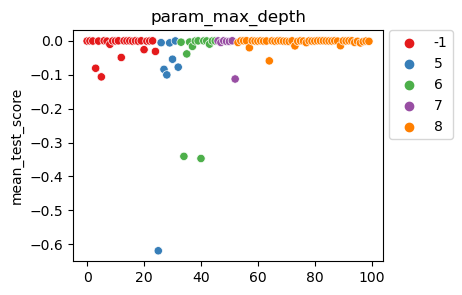

In [37]:
Plot_SearchResult(BS_SMOTE,Countinuous_HP,Discrete_HP)

## 3.4 - Bayesian Search on ADASYN Oversampled Data

In [38]:
if (RERUN_BS == 1):
    conduct_BS(Selected_Sample_Method='ADASYN')
else:
    BS_ADASYN = pd.read_csv('/kaggle/input/creditcardfraud-hyperparameters/BS_ADASYN.csv')

In [39]:
a = ['param_'+i for i in Discrete_HP+Countinuous_HP] + ['mean_test_score','rank_test_score']
BS_ADASYN.sort_values('rank_test_score').head(3)[a]

,param_max_depth,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_child_weight,param_n_estimators,param_min_split_gain,param_num_leaves,param_subsample_for_bin,param_subsample_freq,mean_test_score,rank_test_score
80,5,0.713250,0.200000,38,0.903782,1000,0.0,95,2000,5,-0.000662,1
13,8,0.200000,0.045137,52,0.001000,572,0.0,128,33646,0,-0.000664,2
89,6,0.561762,0.045021,82,0.001000,1000,0.0,114,2000,2,-0.000676,3


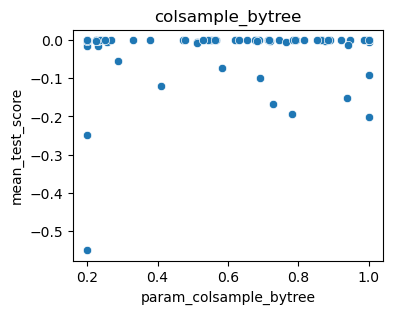

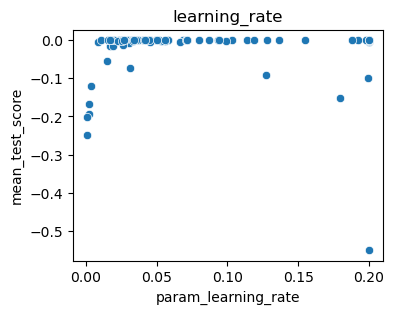

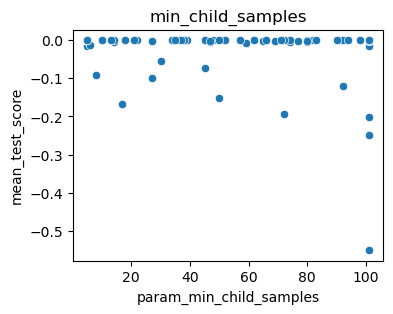

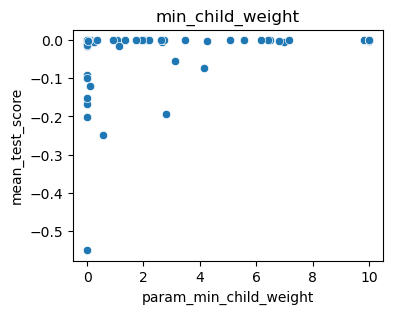

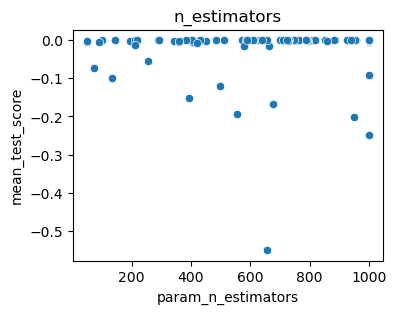

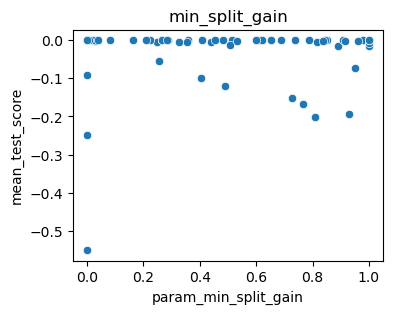

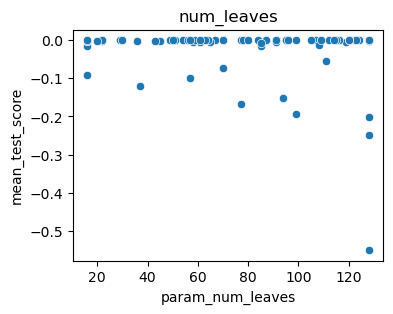

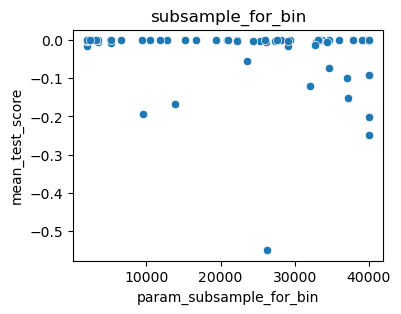

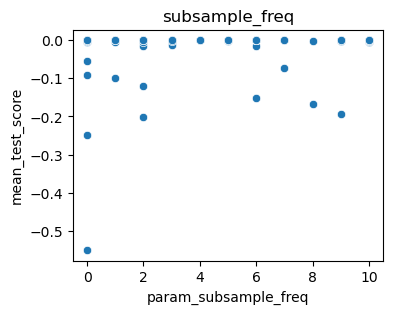

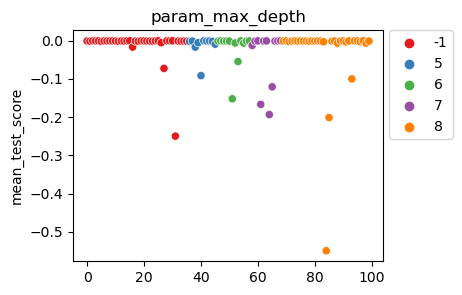

In [40]:
Plot_SearchResult(BS_ADASYN,Countinuous_HP,Discrete_HP)

In [41]:
def Plot_Continuous(df,para,df_name):
    plt.figure(figsize=(4, 3))
    plt.scatter(df['param_'+para],df['mean_test_score'])
    plt.ylim(-0.1,0.01)
    plt.title(para+', '+df_name)
    plt.show()
    return

### Rearching result for the hyperparameter "Learning Rate", with different oversampling methods

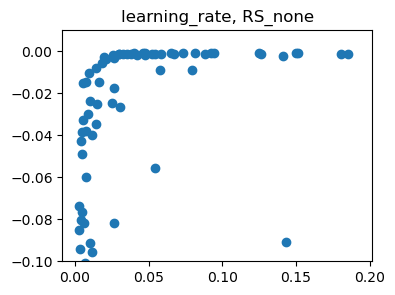

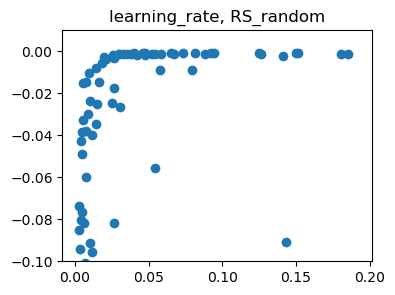

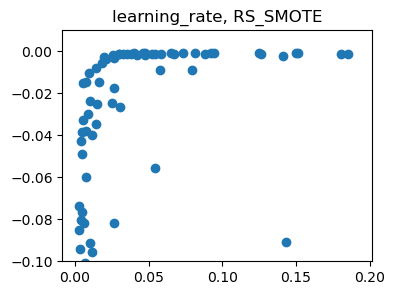

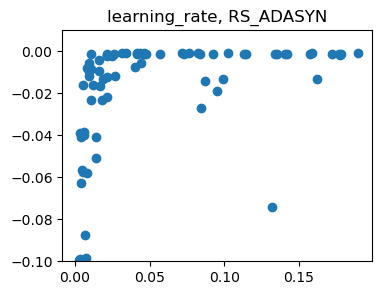

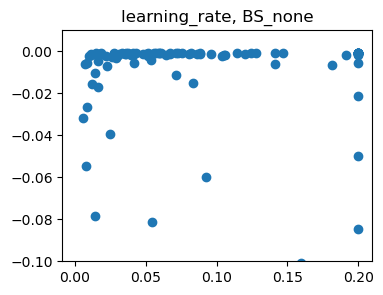

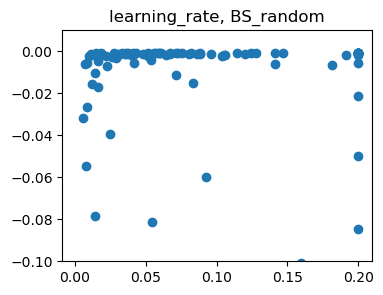

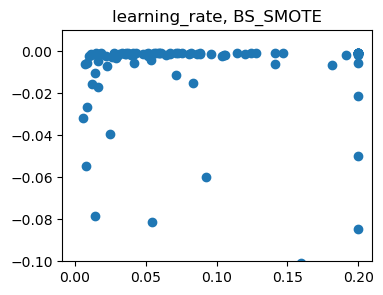

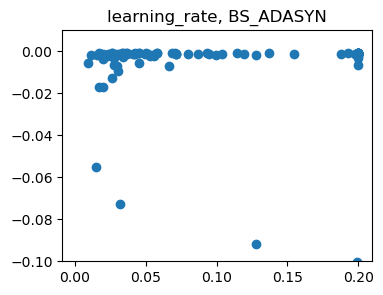

In [42]:
Plot_Continuous(RS_SMOTE,'learning_rate','RS_none')
Plot_Continuous(RS_SMOTE,'learning_rate','RS_random')
Plot_Continuous(RS_SMOTE,'learning_rate','RS_SMOTE')
Plot_Continuous(RS_ADASYN,'learning_rate','RS_ADASYN')
Plot_Continuous(BS_SMOTE,'learning_rate','BS_none')
Plot_Continuous(BS_SMOTE,'learning_rate','BS_random')
Plot_Continuous(BS_SMOTE,'learning_rate','BS_SMOTE')
Plot_Continuous(BS_ADASYN,'learning_rate','BS_ADASYN')